In [52]:
# Imports
import numpy as np

from determined.experimental import Determined
from determined.experimental import client
from models import ObjectDetectionModel
from predict import predict
from utils import check_model
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Set up .detignore file so the checkpoints directory is not packaged into future experiments
!echo checkpoints > .detignore

<img src="https://raw.githubusercontent.com/determined-ai/determined/master/determined-logo.png" align='right' width=150 />

# Building a Pedestrian Detection Model with Determined

<img src="https://www.cis.upenn.edu/~jshi/ped_html/images/PennPed00071_1.png" width=400 />


This notebook will walk through the benefits of building a Deep Learning model with Determined.  We will build an object detection model trained on the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/).


# Table of Contents


<font size="3">
<ol>
  <li>What Modeling looks like Today</li>
  <li>Building a model with Determined
    <ol>
      <li>Single GPU training</li>
      <li>Cluster-scale multi-GPU training</li>
      <li>Adapative hyperparameter search</li>
    </ol>
  </li>
</ol>
</font>

# What modeling looks like without Determined

First let's look at the kind of work modelers do today.  Below, we train a model we found on Github and modified, printing validation set metrics after each epoch.

In [7]:
from models import ObjectDetectionModel

NUM_EPOCHS = 10

model = ObjectDetectionModel({'lr': 0.00045, 'm': 0.72})

try:
    for epoch in range(NUM_EPOCHS):
        print(f"Training epoch {epoch + 1} of {NUM_EPOCHS}")
        model.train_one_epoch()
        iou = model.eval()
        print(f"Validation set average IoU: {iou}\n")
except KeyboardInterrupt:
    pass

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/j9s/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 30.9MB/s] 


Training epoch 1 of 10


Training Epoch 1:   6%|▌         | 2/34 [02:38<42:19, 79.37s/it]


We might also roll our own simple hyperparameter tuning:

In [8]:
import numpy as np

from models import ObjectDetectionModel

def hp_grid_search():
    for lr in np.logspace(-4, -2, num=10):
        for m in np.linspace(0.7, 0.95, num=10):
            print(f"Training model with learning rate {lr} and momentum {m}")
            model = ObjectDetectionModel({'lr': lr, 'm': m})
            model.train_one_epoch()
            iou = model.eval()
            print(f"Validation set average IoU: {iou}\n")

try:
    hp_grid_search()
except KeyboardInterrupt:
    pass

Training model with learning rate 0.0001 and momentum 0.7


Training Epoch 1:  29%|██▉       | 10/34 [12:50<30:49, 77.08s/it]


# What's Missing?

<font size="4">This approach works in theory -- we could get a good model, save it, and use it for predictions.  But we're missing a lot from the ideal state:</font>
<font size="4">
<ul style="margin-top: 15px">
  <li style="margin-bottom: 10px">Distributed training</li>
  <li style="margin-bottom: 10px">Parallel search</li>
  <li style="margin-bottom: 10px">Intelligent checkpointing</li>
  <li style="margin-bottom: 10px">Interruptibility and fault tolerance</li>
  <li                            >Logging of experiment configurations and results </li>
</ul>
</font>

<font size=6><b>Scaled Experimentation with Determined</b></font>

With less work than setting up a limited random search, you can get started with Determined.

## Our First Experiment

For our first example, we run a simple single-GPU training job with fixed hyperparameters.

<img src="https://raw.githubusercontent.com/determined-ai/public_assets/main/images/StartAnExperiment.png" align=left width=330/>

In [10]:
!ls

Object-Detection-PyTorch.ipynb models.py
__pycache__                    notebook.yml
const.yml                      predict.py
data.py                        search.yml
distributed.yml                test.jpeg
model_def.py                   utils.py


In [15]:
master="hpe-shared.determined.ai:8080"

In [30]:
client.login(master={master}, user="nanos", password="changeme123")

TypeError: unhashable type: 'set'

In [32]:
!det -m {master} e create const.yml .

Preparing files (/Users/j9s/git/determined-examples/scratch/object-detection) to send to master... 1.1MB and 11 files 
Created experiment 7


And evaluate its performance:

In [61]:
experiment_id = 5

In [62]:
checkpoint = Determined(master="hpe-shared.determined.ai:8080").get_experiment(experiment_id).top_checkpoint()
print(checkpoint.uuid)

ddf58eb2-0807-4b0f-89ec-3bf448c10afc


In [63]:
model = client.Checkpoint.load_from_path("/System/Volumes/Data/mnt/hpe-shared.determined.ai/" + checkpoint.uuid)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [65]:
bert_experiment_id = 15
bert_checkpoint = Determined(master="hpe-shared.determined.ai:8080").get_experiment(bert_experiment_id).top_checkpoint()
print(bert_checkpoint.uuid)

84576b30-8e70-4361-8331-b4c0c14056da


In [68]:
bert_checkpoint_path = checkpoint.download(path="/System/Volumes/Data/mnt/hpe-shared.determined.ai/" + checkpoint.uuid)
print(bert_checkpoint_path)

/System/Volumes/Data/mnt/hpe-shared.determined.ai/ddf58eb2-0807-4b0f-89ec-3bf448c10afc


In [69]:
bert_model = bert_checkpoint.load(path=bert_checkpoint_path).model

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [70]:
torch.cuda.device_count()

0

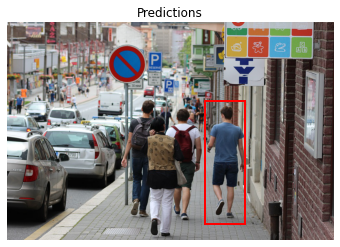

In [5]:
predict(model, 'test.jpg', 0.5)

## Scaling up to Distributed Training

Determined makes it trivial to move from single-GPU to multi-GPU (and even multi-node) training. Here we'll simply modify the config above to request 4 GPUs (slots) instead of 1, and increase the global batch size to increase the data throughput 

In [6]:
!cat distributed.yaml

name: object_detection_const_hp_distributed
labels:
  - "object detection"
  - "project blue"
  - "4 GPU"
environment:
  image: determinedaicustomer/determined-demo-object-detection:0.17.1
data:
  url: https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip
entrypoint: model_def:ObjectDetectionModel
hyperparameters:
  global_batch_size: 16
  learning_rate: 0.02
  momentum: 0.8
  weight_decay: 0.0005
min_validation_period:
  epochs: 4
records_per_epoch: 136
resources:
  slots_per_trial: 4
searcher:
  max_length:
    epochs: 4
  metric: val_avg_iou
  name: single
  smaller_is_better: false
profiling:
  enabled: true
  begin_on_batch: 0
  end_after_batch: null
max_restarts: 5


In [7]:
!det experiment create distributed.yaml .

Preparing files (/run/determined/workdir/shared_fs/User Folders/kurt/Demo) to send to master... 1.3MB and 20 files  
Created experiment 211


In [8]:
dist_experiment_id = 211

In [43]:
dist_checkpoint = Determined().get_experiment(dist_experiment_id).top_checkpoint()
dist_model = dist_checkpoint.load().model

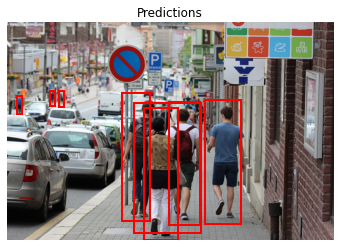

In [44]:
predict(dist_model, 'test.jpg', 0.5)

<img src="https://raw.githubusercontent.com/determined-ai/public_assets/main/images/4GPUexperiment.png" align=left width=530 />

## Run Distributed Hyperparameter Tuning

By simply building a config file and adapting our code to meet the determined trial interface, we can conduct a sophisticated hyperparamter search.  Instructions for how to configure different types of experiments [can be found in the Determined documentation.](https://docs.determined.ai/latest/how-to/index.html)

In [14]:
!cat search.yaml

name: object_detection_hp_search
labels:
  - "object detection"
  - "project blue"
  - "adaptive search"
environment:
  image: determinedaicustomer/determined-demo-object-detection:0.17.1
data:
  url: https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip
entrypoint: model_def:ObjectDetectionModel
hyperparameters:
  global_batch_size: 4
  learning_rate:
    base: 10
    maxval: -2
    minval: -4
    type: log
  momentum:
    maxval: 0.95
    minval: 0.7
    type: double
  weight_decay: 0.0005
min_validation_period:
  epochs: 1
records_per_epoch: 136
resources:
  slots_per_trial: 1
searcher:
  max_length:
    epochs: 4
  max_trials: 24
  max_concurrent_trials: 10
  metric: val_avg_iou
  name: adaptive_asha
  smaller_is_better: false


## Create your Experiment

Now that you've described your experiment, you'll simply need to use the command line interface to submit it to the Determined Cluster.  

In [15]:
!det experiment create search.yaml .

Preparing files (/run/determined/workdir/shared_fs/User Folders/kurt/Demo) to send to master... 909.4KB and 19 files
Created experiment 144


In [45]:
hyper_experiment_id = 144

In [25]:
hyper_checkpoint = Determined().get_experiment(hyper_experiment_id).top_checkpoint()
hyper_model = hyper_checkpoint.load().model

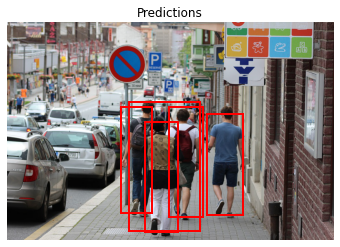

In [26]:
predict(hyper_model, 'test.jpg', 0.5)

<img src="https://raw.githubusercontent.com/determined-ai/public_assets/main/images/12GPUexperiment.png" align=left width=800 />

# Model Registry

After training, we'll want to actually use our model in some sort of system.  Determined provides a model registry to version your trained models, making them easy to retrieve for inference.

In [32]:
experiment_id = 144
MODEL_NAME = "pedestrian-detection"

In [33]:
# Get the best checkpoint from the training
checkpoint = Determined().get_experiment(experiment_id).top_checkpoint()

In [34]:
model = check_model(MODEL_NAME)

In [35]:
model.register_version(checkpoint.uuid)

# Inference

Once your model is versioned in the model registry, using that model for inference is straightforward:

In [36]:
# Retrieve latest checkpoint for a given model name
latest_version = model.get_version()

In [21]:
# Load the model checkpoint into memory
inference_model = latest_version.checkpoint.load().model

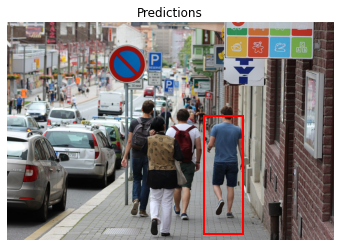

In [22]:
# Run inference as before
predict(inference_model, 'test.jpg')